In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import seaborn as sns
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import anndata
from ec.utils import read_markers_txt
from collections import defaultdict
from sklearn.neighbors import kneighbors_graph
import random
import os

from scipy import stats
from sklearn.neighbors import kneighbors_graph
#from scipy.sparse import random, csr_matrix
from scipy.cluster.hierarchy import single
from scipy.spatial.distance import pdist

from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt

import numpy as np
from numpy.random import default_rng, choice

def nd(arr):
    return np.asarray(arr).reshape(-1)

%matplotlib inline
%config InlineBackend.figure_format='retina'

def concordex_map_full(x, labels, k=20, cluster_rows=False):
    """
    Arguments
    ---------
    x: array
        The square binary connectivity matrix, typically generated from output
        of a k-nearest neighbor algorithm. Assumes sum of each row = k.
    labels: 1D array
        Labels corresponding to each column of x
    k: int
        Default 20. Number of neighbors 
    cluster_rows: bool
        Default False. Determines if rows are clustered in the output. May
        take considerably longer to run if True. See time complexity details
        in `scipy.cluster.hierarchy.linkage`
        
    Returns
    -------
    X: array
        Dimension  correspond to the number of cells (rows)
        and the number of unique labels (columns). 
    order: 
        1D array to determine how columns are ordered in X
    """
    
    n, _ = x.shape
    
    _, neighbors_loc = x.nonzero()
    neighbors_loc = np.array_split(neighbors_loc, n)
    
    # Fails if labels is not a np.array()
    labels = np.array(labels)
    labels_uniq = np.unique(labels)
    
    # Generate output in 2 steps for readability
    counters = [Counter(labels[inds]) for inds in neighbors_loc]
    
    out = np.array([
        itemgetter(*labels_uniq)(c)
         for c in counters
     ])
    
    if (cluster_rows):
        y = pdist(out)
        Z = single(y)
        Z = Z[:, range(2)].reshape(-1)
        
        inds = np.where(Z < n)
        row_order = np.array(Z[inds], dtype=np.int64)
        
        out = out[row_order,:]
        
    return out/k, labels_uniq

In [ ]:
organs = ['ovary',
 'lung',
 'muscle',
 'ileum',
 'prostate',
 'adipose',
 'decidua',
 'retina',
 'skin',
 'kidney',
 'tonsil',
 'colon',
 'mammary',
 'bladder',
 'yolk_sac',
 'eye',
 'rectum',
 'brain',
 'liver',
 'blood',
 'bone_marrow',
 'stomach',
 'thymus',
 'lymph_node',
 'placenta',
 'testis',
 'peritoneal',
 'pancreas']

In [34]:
traces_results = {}
for organ in tqdm(organs):
    print(organ)
    data = f'../files/atlas_assignments/{organ}'
    results = []
    markers_path = f'{data}/markers.other.txt'
    observations = [v for v in os.listdir(f'../files/atlas_assignments/{organ}') if os.path.isfile(f'../files/atlas_assignments/{organ}/{v}/assignments_rank_mx.tsv.gz')]
    for obs in observations:
        try:
            adata = anndata.read_mtx(f'{data}/{obs}/extract.clean.mtx.gz')
            bcs = pd.read_csv(f'{data}/{obs}/assignments_rank_mx.tsv.gz', sep = '\t')

            adata.obs = bcs

            adata_no = adata[adata.obs.eval('label != "Other"')].copy()
            conn = kneighbors_graph(adata_no.X, 20, mode='connectivity', include_self=False)

            df = pd.DataFrame(conn.A, index=adata_no.obs["label"], columns=adata_no.obs["label"])
            t = df.T.groupby("label").sum().T.groupby("label").sum()

            km = t.div(t.sum(1), axis=0)
            mx_trace = np.trace(km)/km.shape[0]

            #t.to_csv(f'{os.path.dirname(os.path.realpath(sys.argv[1]))}/knn_{assignment_type}_{sys.argv[3]}_neighbors.csv')


            # Random assignments traces
            n_iters = 5
            random_mx_traces = []
            for i in range(n_iters):
                random.shuffle(adata_no.obs['label'])
                df = pd.DataFrame(conn.A, index=adata_no.obs["label"], columns=adata_no.obs["label"])
                t = df.T.groupby("label").sum().T.groupby("label").sum()
                km = t.div(t.sum(1), axis=0)
                random_trace = np.trace(km)/km.shape[0]
                random_mx_traces.append(random_trace)
            average_random_mx_trace = np.mean(random_mx_traces)


            results.append(["mx", organ, obs, mx_trace, average_random_mx_trace])
        except:
            continue
    traces_df = pd.DataFrame(results)
    traces_df.columns = ['assignment', 'organ', 'observation', 'trace', 'random_trace']
    traces_df['trace_corrected'] = traces_df['trace'] / traces_df['random_trace']
    #traces_df.to_csv(f'{organ}_traces.csv')
    traces_results[organ] = traces_df

  0%|          | 0/28 [00:00<?, ?it/s]

ovary


  4%|▎         | 1/28 [01:08<30:40, 68.18s/it]

lung


  7%|▋         | 2/28 [08:24<2:03:24, 284.81s/it]

muscle


 11%|█         | 3/28 [08:49<1:09:08, 165.94s/it]

ileum


 14%|█▍        | 4/28 [09:07<42:59, 107.50s/it]  

prostate


 18%|█▊        | 5/28 [09:41<31:09, 81.29s/it] 

adipose


 21%|██▏       | 6/28 [13:20<46:56, 128.01s/it]

decidua


 25%|██▌       | 7/28 [23:23<1:39:09, 283.30s/it]

retina


 29%|██▊       | 8/28 [23:26<1:04:37, 193.90s/it]

skin


 32%|███▏      | 9/28 [29:37<1:18:59, 249.45s/it]

kidney


 36%|███▌      | 10/28 [30:54<58:51, 196.21s/it] 

tonsil


 39%|███▉      | 11/28 [30:57<38:51, 137.17s/it]

colon


 43%|████▎     | 12/28 [31:07<26:12, 98.26s/it] 

mammary


 46%|████▋     | 13/28 [31:45<20:03, 80.24s/it]

bladder


 50%|█████     | 14/28 [32:09<14:45, 63.22s/it]

yolk_sac


 54%|█████▎    | 15/28 [32:25<10:36, 48.96s/it]

eye


 57%|█████▋    | 16/28 [33:26<10:31, 52.60s/it]

rectum


 61%|██████    | 17/28 [33:36<07:18, 39.83s/it]

brain


 64%|██████▍   | 18/28 [38:35<19:36, 117.62s/it]

liver


 68%|██████▊   | 19/28 [1:00:49<1:12:26, 482.99s/it]

blood


 71%|███████▏  | 20/28 [1:18:20<1:27:08, 653.51s/it]

bone_marrow


 75%|███████▌  | 21/28 [1:23:01<1:03:11, 541.66s/it]

stomach


 79%|███████▊  | 22/28 [1:24:58<41:24, 414.08s/it]  

thymus


 82%|████████▏ | 23/28 [1:33:46<37:22, 448.45s/it]

lymph_node


 86%|████████▌ | 24/28 [1:35:19<22:47, 341.76s/it]

placenta


 89%|████████▉ | 25/28 [1:37:23<13:48, 276.28s/it]

testis


 93%|█████████▎| 26/28 [1:42:46<09:40, 290.28s/it]

peritoneal


 96%|█████████▋| 27/28 [1:45:14<03:53, 233.89s/it]

pancreas


ValueError: Length mismatch: Expected axis has 0 elements, new values have 5 elements

In [35]:
traces_results

{'ovary':    assignment  organ observation     trace  random_trace  trace_corrected
 0          mx  ovary  GSM3319036  0.496959      0.142302         3.492272
 1          mx  ovary  GSM3319047  0.155368      0.121930         1.274243
 2          mx  ovary  GSM3557972  0.260778      0.137166         1.901188
 3          mx  ovary  GSM3557967  0.314576      0.137939         2.280548
 4          mx  ovary  GSM3557961  0.372034      0.141610         2.627175
 5          mx  ovary  GSM3319037  0.721614      0.142616         5.059824
 6          mx  ovary  GSM3557965  0.318680      0.138087         2.307819
 7          mx  ovary  GSM3319046  0.587603      0.138550         4.241096
 8          mx  ovary  GSM3557964  0.401435      0.137484         2.919864
 9          mx  ovary  GSM3319041  0.303379      0.138864         2.184721
 10         mx  ovary  GSM3319033  0.574474      0.142731         4.024871
 11         mx  ovary  GSM3557959  0.240299      0.141739         1.695359
 12         mx  

In [36]:
good_organs = ['ovary', 'ileum', 'adipose', 'decidua', 
              'skin', 'kidney', 'mammary', 'rectum', 'brain', 
              'liver', 'bone_marrow', 'stomach', 'thymus','testis', 'peritoneal']

In [37]:
df

label,Epithelial cell,Epithelial cell,Epithelial cell,T cell,Mast cell,Mast cell,Mast cell,Epithelial cell,T cell,Mast cell,...,Mast cell,Epithelial cell,Mast cell,T cell,Mast cell,Natural killer cell,T cell,T cell,T cell,Mast cell
label,,,,,,,,,,,,,,,,,,,,,
Epithelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Epithelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Epithelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mast cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Natural killer cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


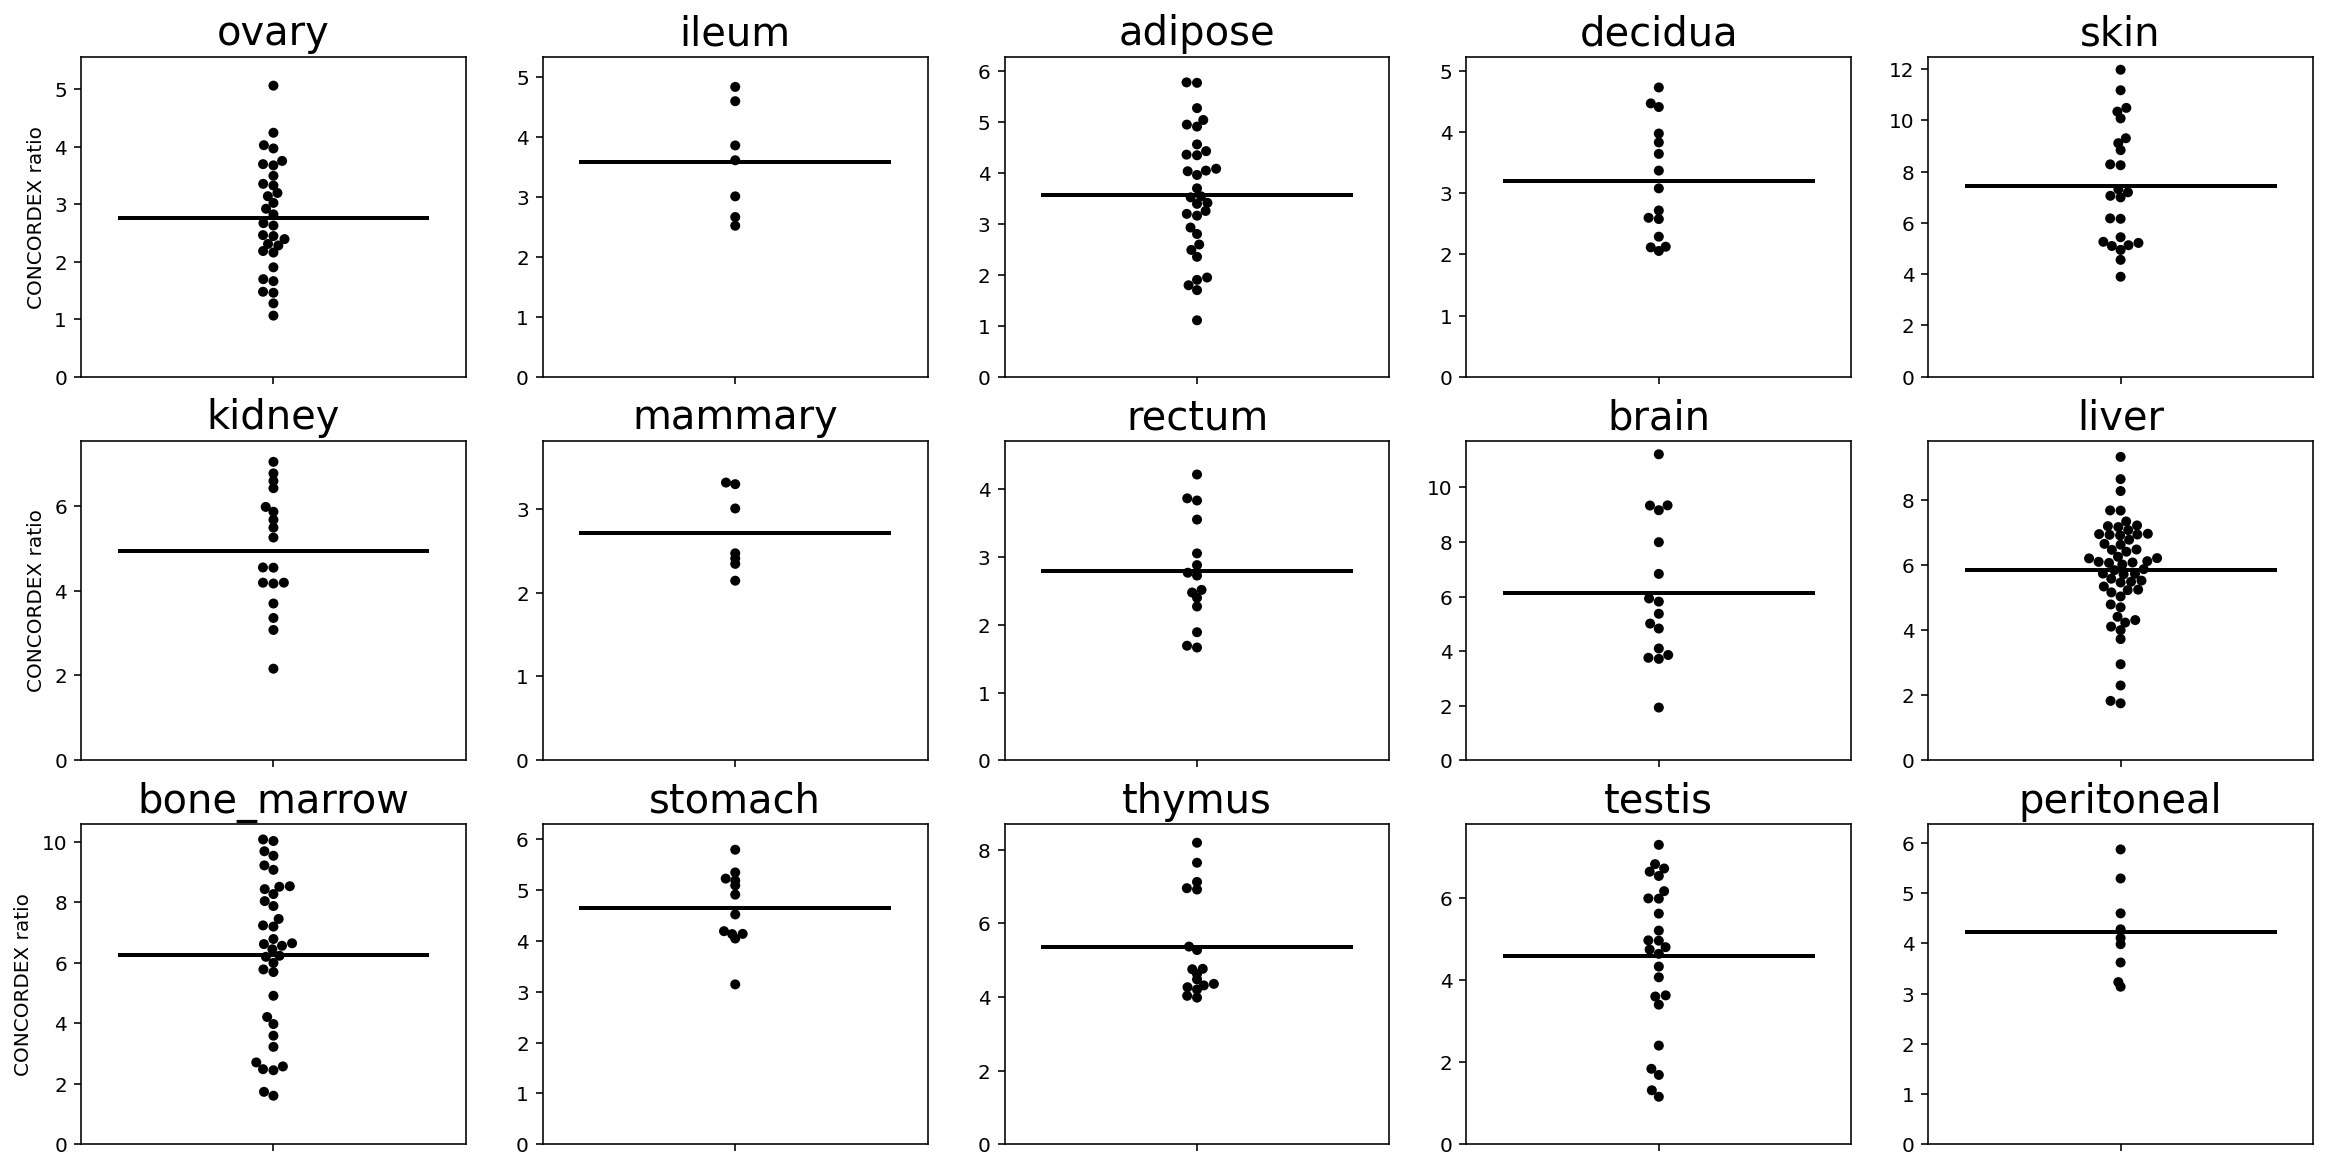

In [38]:
results_by_organ = {}
fig, ax = plt.subplots(3, 5, figsize=(20,10))
ax = ax.flatten()
i=0
for organ, axis in zip(good_organs, ax):
    try:
        #data = pd.read_csv(f'{organ}_traces.csv')
        df = traces_results[organ]
        #results_by_organ[organ] = data
        p = sns.swarmplot(data = df, y = 'trace_corrected', ax = axis, color = 'black')
        sns.boxplot(showmeans=True,
                    meanline=True,
                    meanprops={'color': 'k', 'ls': '-', 'lw': 2},
                    medianprops={'visible': False},
                    whiskerprops={'visible': False},
                    zorder=10,
                    y="trace_corrected",
                    data=df,
                    showfliers=False,
                    showbox=False,
                    showcaps=False,
                    ax=axis)
        axis.set_title(f'{organ}', fontsize = 20)
        if i%5 == 0:
            
            axis.set_ylabel("CONCORDEX ratio")
        else:
            axis.set_ylabel('')
        axis.set_ylim(0,np.max(df['trace_corrected'] + 0.5))
        i+=1
    except:
        continue
        
#!mkdir figures
#plt.savefig('figures/fig_s6.png')